In [2]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:86% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:130px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:15px;}
</style>
"""))

# Linear Regression
sklearn.linear_model

C:\Users\wjdwh\AppData\Local\Temp\ipykernel_24596\2344577634.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[num_cols] = scaler.fit_transform(X[num_cols])


----- Validation Set Evaluation -----
Validation RMSE: 0.00, MAE: 0.00, R2: 1.000


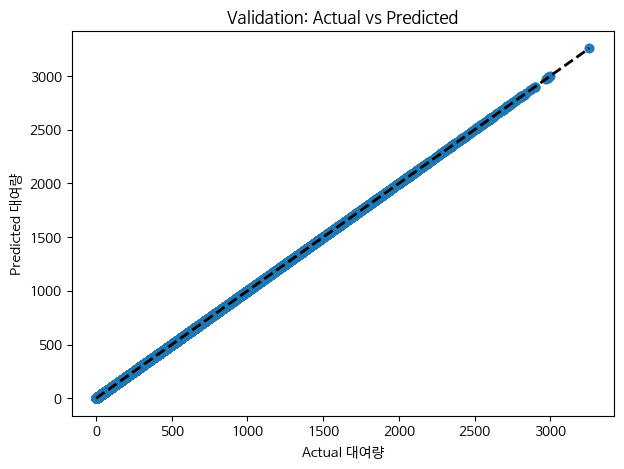

----- Test Set Evaluation -----
Test RMSE: 0.00, MAE: 0.00, R2: 1.000


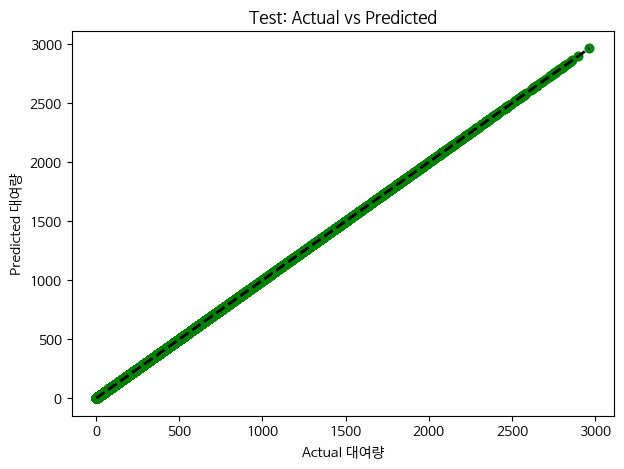

예측 대여량: 117.0


C:\Users\wjdwh\.conda\envs\ml-dl-nlp\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [1]:
import pandas as pd
import numpy as np
import joblib
from datetime import datetime, timedelta
import holidays
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
plt.rc('font',family = 'Hancom Gothic')
# 데이터 로딩 및 전처리(동일)
df = pd.read_csv('LSTM최종데이터_X_Y_라벨링등전.csv')
df = df.dropna(subset=['대여량'])

df['일시'] = pd.to_datetime(df['일시'])
df['연'] = df['일시'].dt.year
df['월'] = df['일시'].dt.month
df['일'] = df['일시'].dt.day
df['시'] = df['일시'].dt.hour
df['요일'] = df['일시'].dt.dayofweek
start_year = df['연'].min()
end_year = df['연'].max()
kr_holidays = holidays.KR(years=range(start_year, end_year+1))
df['공휴일'] = df['일시'].dt.floor('D').isin(kr_holidays).astype(int)

df['key'] = df['행정구'] + '_' + df['월'].astype(str) + '_' + df['일'].astype(str) + '_' + df['시'].astype(str)
df['일시_1년전'] = df['일시'] - pd.DateOffset(years=1)
df['key_1년전'] = df['행정구'] + '_' + df['일시_1년전'].dt.month.astype(str) + '_' + df['일시_1년전'].dt.day.astype(str) + '_' + df['일시_1년전'].dt.hour.astype(str)
cols_to_copy = ['key', '대여량', '총생활인구수']
df_1y = df[cols_to_copy].copy()
df_1y.columns = [c + '_1년전' if c != 'key' else 'key_1년전' for c in cols_to_copy]
df = pd.merge(df, df_1y, how='left', on='key_1년전')
df = df.dropna(subset=['대여량_1년전', '총생활인구수_1년전'])

df['인구_증감'] = df['총생활인구수'] - df['총생활인구수_1년전']
df['인구_증감률'] = (df['총생활인구수'] - df['총생활인구수_1년전']) / (df['총생활인구수_1년전'] + 1)
df['대여량_증감'] = df['대여량'] - df['대여량_1년전']
df['대여량_증감률'] = (df['대여량'] - df['대여량_1년전']) / (df['대여량_1년전'] + 1)

from sklearn.preprocessing import LabelEncoder, StandardScaler
label_cols = ['행정구']
le_dict = {}
for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

feature_cols = [
    '행정구', '월', '일', '시', '요일', '총생활인구수', '강수', '기온', '습도', '풍속',
    '주말구분', '공휴일',
    '대여량_1년전', '총생활인구수_1년전',
    '대여량_증감', '대여량_증감률', '인구_증감', '인구_증감률'
]
X = df[feature_cols]
y = df['대여량']

num_cols = [
    '총생활인구수', '강수', '기온', '습도', '풍속',
    '대여량_1년전', '총생활인구수_1년전',
    '대여량_증감', '대여량_증감률', '인구_증감', '인구_증감률'
]
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

train_idx = df['연'] <= 2022
val_idx = (df['연'] == 2023)
test_idx = (df['연'] == 2024)
X_train, X_val, X_test = X[train_idx], X[val_idx], X[test_idx]
y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx]

# --------- 선형회귀 모델 ---------
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# --------- 평가(검증/테스트) 및 시각화 ---------
def regression_metrics(y_true, y_pred, title=""):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{title} RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.3f}")
    return rmse, mae, r2

# 검증셋
y_pred_val = model_lr.predict(X_val)
print("----- Validation Set Evaluation -----")
regression_metrics(y_val, y_pred_val, title="Validation")

plt.figure(figsize=(7,5))
plt.scatter(y_val, y_pred_val, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.xlabel('Actual 대여량')
plt.ylabel('Predicted 대여량')
plt.title('Validation: Actual vs Predicted')
plt.show()

# 테스트셋
y_pred_test = model_lr.predict(X_test)
print("----- Test Set Evaluation -----")
regression_metrics(y_test, y_pred_test, title="Test")

plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred_test, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual 대여량')
plt.ylabel('Predicted 대여량')
plt.title('Test: Actual vs Predicted')
plt.show()

# 모델, 스케일러, 인코더, feature 리스트 저장
joblib.dump(model_lr, 'best_lr_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le_dict, 'labelencoders.pkl')
joblib.dump(feature_cols, 'featurecols.pkl')
joblib.dump(num_cols, 'numcols.pkl')

# --------- 예측 함수(선형회귀) ---------
def predict_bike_demand_regression(행정구, 강수, 습도, 풍속, 기온):
    """
    행정구명, 강수, 습도, 풍속, 기온을 입력받아
    해당 시간의 공공자전거 대여량을 예측(실수값)하는 함수
    """
    import pandas as pd
    import numpy as np
    import joblib
    from datetime import datetime, timedelta
    import holidays

    le_dict = joblib.load('labelencoders.pkl')
    scaler = joblib.load('scaler.pkl')
    feature_cols = joblib.load('featurecols.pkl')
    num_cols = joblib.load('numcols.pkl')
    model = joblib.load('best_lr_model.pkl')

    now = datetime.now()
    년, 월, 일, 시 = now.year, now.month, now.day, now.hour
    요일 = now.weekday()
    주말구분 = 1 if 요일 >= 5 else 0
    kr_holidays = holidays.KR(years=[년])
    공휴일 = int(now.date() in kr_holidays)

    dt_1y = now - timedelta(days=365)
    년_1, 월_1, 일_1, 시_1 = dt_1y.year, dt_1y.month, dt_1y.day, dt_1y.hour
    row_1y = df[(df['행정구'] == le_dict['행정구'].transform([행정구])[0]) &
                (df['연'] == 년_1) & (df['월'] == 월_1) &
                (df['일'] == 일_1) & (df['시'] == 시_1)]
    if row_1y.empty:
        raise ValueError('1년 전 데이터가 존재하지 않습니다.')
    대여량_1년전 = row_1y['대여량'].values[0]
    총생활인구수_1년전 = row_1y['총생활인구수'].values[0]
    총생활인구수 = 총생활인구수_1년전

    대여량_증감 = 0
    대여량_증감률 = 0
    인구_증감 = 0
    인구_증감률 = 0

    input_dict = {
        '행정구': le_dict['행정구'].transform([행정구])[0],
        '월': 월,
        '일': 일,
        '시': 시,
        '요일': 요일,
        '총생활인구수': 총생활인구수,
        '강수': 강수,
        '기온': 기온,
        '습도': 습도,
        '풍속': 풍속,
        '주말구분': 주말구분,
        '공휴일': 공휴일,
        '대여량_1년전': 대여량_1년전,
        '총생활인구수_1년전': 총생활인구수_1년전,
        '대여량_증감': 대여량_증감,
        '대여량_증감률': 대여량_증감률,
        '인구_증감': 인구_증감,
        '인구_증감률': 인구_증감률
    }
    input_df = pd.DataFrame([input_dict])
    input_df[num_cols] = scaler.transform(input_df[num_cols])
    X_input = input_df[feature_cols].values
    pred = model.predict(X_input)
    return float(pred[0])

# 사용 예시
pred = predict_bike_demand_regression('강남구', 0.2, 60, 2.5, 21)
print(f"예측 대여량: {pred:.1f}")


# DNN

C:\Users\wjdwh\AppData\Local\Temp\ipykernel_24596\370671173.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[num_cols] = scaler.fit_transform(X[num_cols])


Epoch 1/100

Epoch 1: val_loss improved from inf to 21.93105, saving model to best_dnn_reg_model.h5
3414/3414 - 11s - loss: 1785.1659 - mae: 18.1818 - val_loss: 21.9311 - val_mae: 3.3804 - 11s/epoch - 3ms/step
Epoch 2/100

Epoch 2: val_loss did not improve from 21.93105
3414/3414 - 9s - loss: 279.4064 - mae: 9.3903 - val_loss: 99.6644 - val_mae: 8.2682 - 9s/epoch - 3ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 21.93105
3414/3414 - 9s - loss: 253.9483 - mae: 8.7843 - val_loss: 42.5289 - val_mae: 3.8292 - 9s/epoch - 3ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 21.93105
3414/3414 - 9s - loss: 215.0320 - mae: 8.0462 - val_loss: 691.8365 - val_mae: 13.2083 - 9s/epoch - 3ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 21.93105
3414/3414 - 9s - loss: 162.8176 - mae: 6.9190 - val_loss: 2359.8408 - val_mae: 25.6480 - 9s/epoch - 3ms/step
Epoch 6/100

Epoch 6: val_loss did not improve from 21.93105
3414/3414 - 9s - loss: 131.2152 - mae: 6.1901 - val_loss

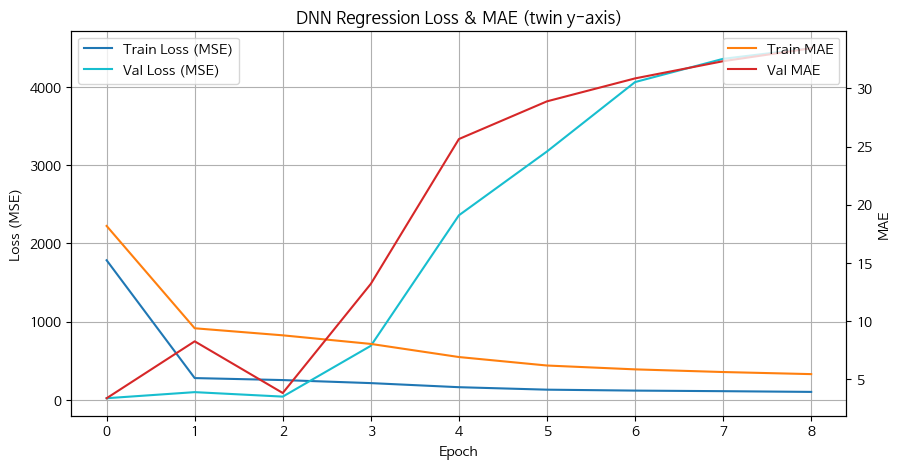

27382/27382 [==============================] - 20s 717us/step
----- Validation Set Evaluation -----
Validation RMSE: 4.68, MAE: 3.38, R2: 1.000


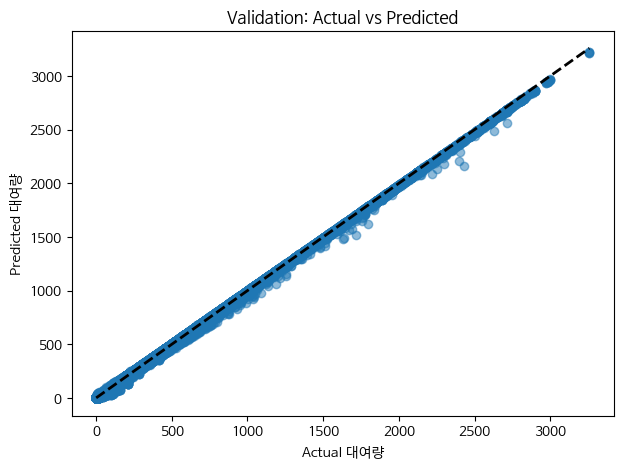

27461/27461 [==============================] - 19s 690us/step
----- Test Set Evaluation -----
Test RMSE: 4.61, MAE: 3.42, R2: 1.000


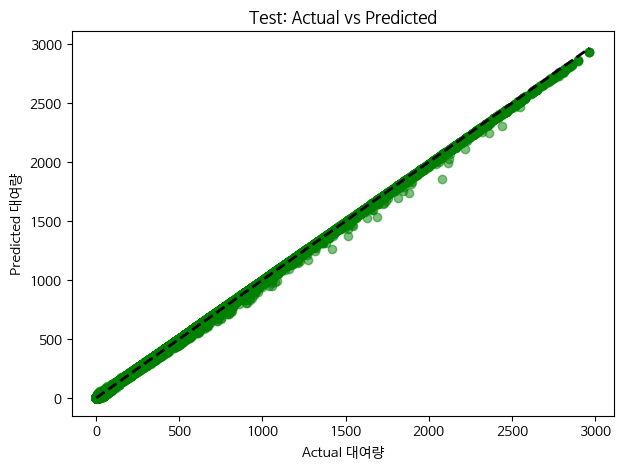

1/1 [==============================] - 0s 35ms/step
예측 대여량: 117.7


In [4]:
import pandas as pd
import numpy as np
import joblib
from datetime import datetime, timedelta
import holidays
import matplotlib.pyplot as plt
plt.rc('font',family = 'Hancom Gothic')
# 데이터 로딩 및 전처리(동일)
df = pd.read_csv('LSTM최종데이터_X_Y_라벨링등전.csv')
df = df.dropna(subset=['대여량'])

df['일시'] = pd.to_datetime(df['일시'])
df['연'] = df['일시'].dt.year
df['월'] = df['일시'].dt.month
df['일'] = df['일시'].dt.day
df['시'] = df['일시'].dt.hour
df['요일'] = df['일시'].dt.dayofweek
start_year = df['연'].min()
end_year = df['연'].max()
kr_holidays = holidays.KR(years=range(start_year, end_year+1))
df['공휴일'] = df['일시'].dt.floor('D').isin(kr_holidays).astype(int)

df['key'] = df['행정구'] + '_' + df['월'].astype(str) + '_' + df['일'].astype(str) + '_' + df['시'].astype(str)
df['일시_1년전'] = df['일시'] - pd.DateOffset(years=1)
df['key_1년전'] = df['행정구'] + '_' + df['일시_1년전'].dt.month.astype(str) + '_' + df['일시_1년전'].dt.day.astype(str) + '_' + df['일시_1년전'].dt.hour.astype(str)
cols_to_copy = ['key', '대여량', '총생활인구수']
df_1y = df[cols_to_copy].copy()
df_1y.columns = [c + '_1년전' if c != 'key' else 'key_1년전' for c in cols_to_copy]
df = pd.merge(df, df_1y, how='left', on='key_1년전')
df = df.dropna(subset=['대여량_1년전', '총생활인구수_1년전'])

df['인구_증감'] = df['총생활인구수'] - df['총생활인구수_1년전']
df['인구_증감률'] = (df['총생활인구수'] - df['총생활인구수_1년전']) / (df['총생활인구수_1년전'] + 1)
df['대여량_증감'] = df['대여량'] - df['대여량_1년전']
df['대여량_증감률'] = (df['대여량'] - df['대여량_1년전']) / (df['대여량_1년전'] + 1)

from sklearn.preprocessing import LabelEncoder, StandardScaler
label_cols = ['행정구']
le_dict = {}
for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

feature_cols = [
    '행정구', '월', '일', '시', '요일', '총생활인구수', '강수', '기온', '습도', '풍속',
    '주말구분', '공휴일',
    '대여량_1년전', '총생활인구수_1년전',
    '대여량_증감', '대여량_증감률', '인구_증감', '인구_증감률'
]
X = df[feature_cols]
y = df['대여량']

num_cols = [
    '총생활인구수', '강수', '기온', '습도', '풍속',
    '대여량_1년전', '총생활인구수_1년전',
    '대여량_증감', '대여량_증감률', '인구_증감', '인구_증감률'
]
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

train_idx = df['연'] <= 2022
val_idx = (df['연'] == 2023)
test_idx = (df['연'] == 2024)
X_train, X_val, X_test = X[train_idx], X[val_idx], X[test_idx]
y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx]

# ----------------- DNN 회귀 모델 -----------------
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

input_dim = X_train.shape[1]
model_dnn_reg = Sequential([
    Dense(256, input_dim=input_dim, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
])
model_dnn_reg.compile(optimizer='adam', loss='mse', metrics=['mae'])
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
mc = ModelCheckpoint('best_dnn_reg_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
history = model_dnn_reg.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_data=(X_val, y_val),
    callbacks=[es, mc],
    verbose=2
)

# 학습과정 그래프 시각화 (Loss/MAE twin-y)
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(history.history['loss'], label='Train Loss (MSE)', color='tab:blue')
ax1.plot(history.history['val_loss'], label='Val Loss (MSE)', color='tab:cyan')
ax1.set_ylabel('Loss (MSE)')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper left')
ax1.grid(True)
ax2 = ax1.twinx()
ax2.plot(history.history['mae'], label='Train MAE', color='tab:orange')
ax2.plot(history.history['val_mae'], label='Val MAE', color='tab:red')
ax2.set_ylabel('MAE')
ax2.legend(loc='upper right')
plt.title('DNN Regression Loss & MAE (twin y-axis)')
plt.show()

# --------- 평가(검증/테스트) 및 시각화 ---------
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def regression_metrics(y_true, y_pred, title=""):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{title} RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.3f}")
    return rmse, mae, r2

# 검증셋
y_pred_val = model_dnn_reg.predict(X_val).flatten()
print("----- Validation Set Evaluation -----")
regression_metrics(y_val, y_pred_val, title="Validation")

plt.figure(figsize=(7,5))
plt.scatter(y_val, y_pred_val, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.xlabel('Actual 대여량')
plt.ylabel('Predicted 대여량')
plt.title('Validation: Actual vs Predicted')
plt.show()

# 테스트셋
y_pred_test = model_dnn_reg.predict(X_test).flatten()
print("----- Test Set Evaluation -----")
regression_metrics(y_test, y_pred_test, title="Test")

plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred_test, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual 대여량')
plt.ylabel('Predicted 대여량')
plt.title('Test: Actual vs Predicted')
plt.show()

# 모델, 스케일러, 인코더, feature 리스트 저장
model_dnn_reg.save('best_dnn_reg_model.h5')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le_dict, 'labelencoders.pkl')
joblib.dump(feature_cols, 'featurecols.pkl')
joblib.dump(num_cols, 'numcols.pkl')

# --------- 예측 함수(DNN 회귀) ---------
def predict_bike_demand_regression(행정구, 강수, 습도, 풍속, 기온):
    """
    행정구명, 강수, 습도, 풍속, 기온을 입력받아
    해당 시간의 공공자전거 대여량을 예측(실수값)하는 함수 (DNN 회귀)
    """
    import pandas as pd
    import numpy as np
    import joblib
    from datetime import datetime, timedelta
    import holidays
    import tensorflow as tf

    le_dict = joblib.load('labelencoders.pkl')
    scaler = joblib.load('scaler.pkl')
    feature_cols = joblib.load('featurecols.pkl')
    num_cols = joblib.load('numcols.pkl')
    model = tf.keras.models.load_model('best_dnn_reg_model.h5')

    now = datetime.now()
    년, 월, 일, 시 = now.year, now.month, now.day, now.hour
    요일 = now.weekday()
    주말구분 = 1 if 요일 >= 5 else 0
    kr_holidays = holidays.KR(years=[년])
    공휴일 = int(now.date() in kr_holidays)

    dt_1y = now - timedelta(days=365)
    년_1, 월_1, 일_1, 시_1 = dt_1y.year, dt_1y.month, dt_1y.day, dt_1y.hour
    row_1y = df[(df['행정구'] == le_dict['행정구'].transform([행정구])[0]) &
                (df['연'] == 년_1) & (df['월'] == 월_1) &
                (df['일'] == 일_1) & (df['시'] == 시_1)]
    if row_1y.empty:
        raise ValueError('1년 전 데이터가 존재하지 않습니다.')
    대여량_1년전 = row_1y['대여량'].values[0]
    총생활인구수_1년전 = row_1y['총생활인구수'].values[0]
    총생활인구수 = 총생활인구수_1년전

    대여량_증감 = 0
    대여량_증감률 = 0
    인구_증감 = 0
    인구_증감률 = 0

    input_dict = {
        '행정구': le_dict['행정구'].transform([행정구])[0],
        '월': 월,
        '일': 일,
        '시': 시,
        '요일': 요일,
        '총생활인구수': 총생활인구수,
        '강수': 강수,
        '기온': 기온,
        '습도': 습도,
        '풍속': 풍속,
        '주말구분': 주말구분,
        '공휴일': 공휴일,
        '대여량_1년전': 대여량_1년전,
        '총생활인구수_1년전': 총생활인구수_1년전,
        '대여량_증감': 대여량_증감,
        '대여량_증감률': 대여량_증감률,
        '인구_증감': 인구_증감,
        '인구_증감률': 인구_증감률
    }
    input_df = pd.DataFrame([input_dict])
    input_df[num_cols] = scaler.transform(input_df[num_cols])
    X_input = input_df[feature_cols].values
    pred = model.predict(X_input)
    return float(pred[0])

# 사용 예시
pred = predict_bike_demand_regression('강남구', 0.2, 60, 2.5, 21)
print(f"예측 대여량: {pred:.1f}")

# LSTM Regressor

C:\Users\wjdwh\AppData\Local\Temp\ipykernel_24596\4095688145.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[num_cols] = scaler.fit_transform(X[num_cols])


Epoch 1/100

Epoch 1: val_loss improved from inf to 78.07100, saving model to best_lstm_reg_model.h5
3414/3414 - 15s - loss: 1745.8795 - mae: 14.5156 - val_loss: 78.0710 - val_mae: 3.3568 - 15s/epoch - 4ms/step
Epoch 2/100

Epoch 2: val_loss did not improve from 78.07100
3414/3414 - 13s - loss: 263.6695 - mae: 9.1325 - val_loss: 88.2595 - val_mae: 4.1571 - 13s/epoch - 4ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 78.07100
3414/3414 - 12s - loss: 245.1930 - mae: 8.6946 - val_loss: 89.0776 - val_mae: 3.9937 - 12s/epoch - 3ms/step
Epoch 4/100

Epoch 4: val_loss improved from 78.07100 to 52.50716, saving model to best_lstm_reg_model.h5
3414/3414 - 12s - loss: 234.3554 - mae: 8.3625 - val_loss: 52.5072 - val_mae: 4.5123 - 12s/epoch - 4ms/step
Epoch 5/100

Epoch 5: val_loss improved from 52.50716 to 48.34936, saving model to best_lstm_reg_model.h5
3414/3414 - 12s - loss: 223.5141 - mae: 8.0152 - val_loss: 48.3494 - val_mae: 3.6948 - 12s/epoch - 4ms/step
Epoch 6/100

Epoch 6: v

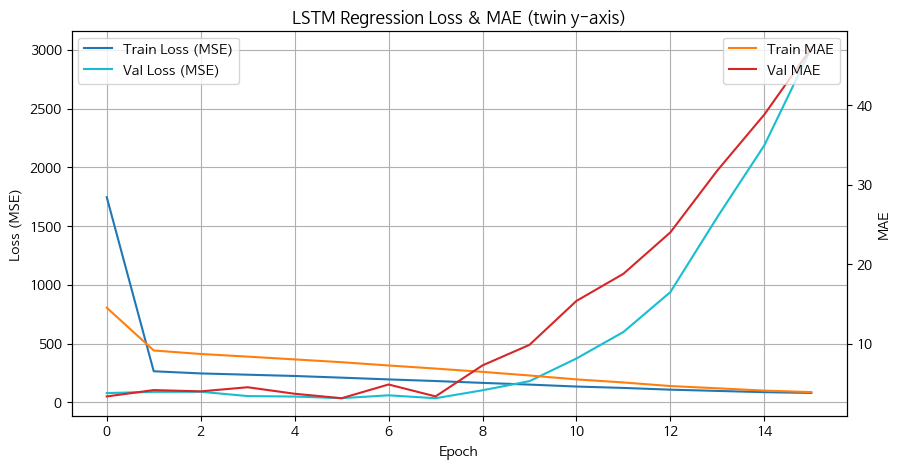

27382/27382 [==============================] - 30s 1ms/step
----- Validation Set Evaluation -----
Validation RMSE: 5.85, MAE: 3.37, R2: 0.999


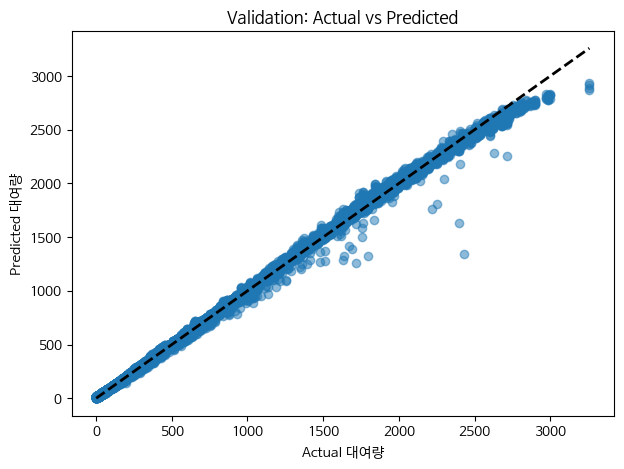

27461/27461 [==============================] - 30s 1ms/step
----- Test Set Evaluation -----
Test RMSE: 5.36, MAE: 3.29, R2: 1.000


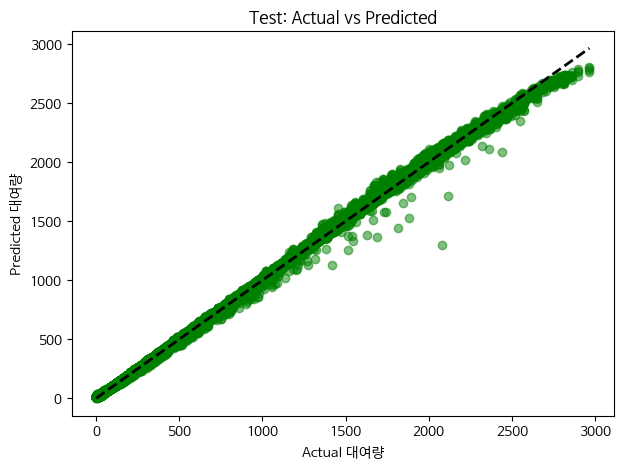

1/1 [==============================] - 0s 198ms/step
예측 대여량: 113.8


In [5]:
import pandas as pd
import numpy as np
import joblib
from datetime import datetime, timedelta
import holidays
import matplotlib.pyplot as plt
plt.rc('font', family = 'Hancom Gothic')
# 데이터 로딩 및 전처리(동일)
df = pd.read_csv('LSTM최종데이터_X_Y_라벨링등전.csv')
df = df.dropna(subset=['대여량'])

df['일시'] = pd.to_datetime(df['일시'])
df['연'] = df['일시'].dt.year
df['월'] = df['일시'].dt.month
df['일'] = df['일시'].dt.day
df['시'] = df['일시'].dt.hour
df['요일'] = df['일시'].dt.dayofweek
start_year = df['연'].min()
end_year = df['연'].max()
kr_holidays = holidays.KR(years=range(start_year, end_year+1))
df['공휴일'] = df['일시'].dt.floor('D').isin(kr_holidays).astype(int)

df['key'] = df['행정구'] + '_' + df['월'].astype(str) + '_' + df['일'].astype(str) + '_' + df['시'].astype(str)
df['일시_1년전'] = df['일시'] - pd.DateOffset(years=1)
df['key_1년전'] = df['행정구'] + '_' + df['일시_1년전'].dt.month.astype(str) + '_' + df['일시_1년전'].dt.day.astype(str) + '_' + df['일시_1년전'].dt.hour.astype(str)
cols_to_copy = ['key', '대여량', '총생활인구수']
df_1y = df[cols_to_copy].copy()
df_1y.columns = [c + '_1년전' if c != 'key' else 'key_1년전' for c in cols_to_copy]
df = pd.merge(df, df_1y, how='left', on='key_1년전')
df = df.dropna(subset=['대여량_1년전', '총생활인구수_1년전'])

df['인구_증감'] = df['총생활인구수'] - df['총생활인구수_1년전']
df['인구_증감률'] = (df['총생활인구수'] - df['총생활인구수_1년전']) / (df['총생활인구수_1년전'] + 1)
df['대여량_증감'] = df['대여량'] - df['대여량_1년전']
df['대여량_증감률'] = (df['대여량'] - df['대여량_1년전']) / (df['대여량_1년전'] + 1)

from sklearn.preprocessing import LabelEncoder, StandardScaler
label_cols = ['행정구']
le_dict = {}
for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

feature_cols = [
    '행정구', '월', '일', '시', '요일', '총생활인구수', '강수', '기온', '습도', '풍속',
    '주말구분', '공휴일',
    '대여량_1년전', '총생활인구수_1년전',
    '대여량_증감', '대여량_증감률', '인구_증감', '인구_증감률'
]
X = df[feature_cols]
y = df['대여량']

num_cols = [
    '총생활인구수', '강수', '기온', '습도', '풍속',
    '대여량_1년전', '총생활인구수_1년전',
    '대여량_증감', '대여량_증감률', '인구_증감', '인구_증감률'
]
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

train_idx = df['연'] <= 2022
val_idx = (df['연'] == 2023)
test_idx = (df['연'] == 2024)
X_train, X_val, X_test = X[train_idx], X[val_idx], X[test_idx]
y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx]

# LSTM 입력차원으로 변환 (batch, time=1, feature)
X_train_lstm = np.expand_dims(X_train.values, axis=1)
X_val_lstm = np.expand_dims(X_val.values, axis=1)
X_test_lstm = np.expand_dims(X_test.values, axis=1)

# ----------------- LSTM 회귀 모델 -----------------
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
model_lstm_reg = Sequential([
    LSTM(128, input_shape=input_shape, return_sequences=False),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
])
model_lstm_reg.compile(optimizer='adam', loss='mse', metrics=['mae'])
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
mc = ModelCheckpoint('best_lstm_reg_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
history = model_lstm_reg.fit(
    X_train_lstm, y_train,
    epochs=100,
    batch_size=512,
    validation_data=(X_val_lstm, y_val),
    callbacks=[es, mc],
    verbose=2
)

# 학습과정 그래프 시각화 (Loss/MAE twin-y)
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(history.history['loss'], label='Train Loss (MSE)', color='tab:blue')
ax1.plot(history.history['val_loss'], label='Val Loss (MSE)', color='tab:cyan')
ax1.set_ylabel('Loss (MSE)')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper left')
ax1.grid(True)
ax2 = ax1.twinx()
ax2.plot(history.history['mae'], label='Train MAE', color='tab:orange')
ax2.plot(history.history['val_mae'], label='Val MAE', color='tab:red')
ax2.set_ylabel('MAE')
ax2.legend(loc='upper right')
plt.title('LSTM Regression Loss & MAE (twin y-axis)')
plt.show()

# --------- 평가(검증/테스트) 및 시각화 ---------
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def regression_metrics(y_true, y_pred, title=""):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{title} RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.3f}")
    return rmse, mae, r2

# 검증셋
y_pred_val = model_lstm_reg.predict(X_val_lstm).flatten()
print("----- Validation Set Evaluation -----")
regression_metrics(y_val, y_pred_val, title="Validation")

plt.figure(figsize=(7,5))
plt.scatter(y_val, y_pred_val, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.xlabel('Actual 대여량')
plt.ylabel('Predicted 대여량')
plt.title('Validation: Actual vs Predicted')
plt.show()

# 테스트셋
y_pred_test = model_lstm_reg.predict(X_test_lstm).flatten()
print("----- Test Set Evaluation -----")
regression_metrics(y_test, y_pred_test, title="Test")

plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred_test, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual 대여량')
plt.ylabel('Predicted 대여량')
plt.title('Test: Actual vs Predicted')
plt.show()

# 모델, 스케일러, 인코더, feature 리스트 저장
model_lstm_reg.save('best_lstm_reg_model.h5')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le_dict, 'labelencoders.pkl')
joblib.dump(feature_cols, 'featurecols.pkl')
joblib.dump(num_cols, 'numcols.pkl')

# --------- 예측 함수(LSTM 회귀) ---------
def predict_bike_demand_regression(행정구, 강수, 습도, 풍속, 기온):
    """
    행정구명, 강수, 습도, 풍속, 기온을 입력받아
    해당 시간의 공공자전거 대여량을 예측(실수값)하는 함수 (LSTM 회귀)
    """
    import pandas as pd
    import numpy as np
    import joblib
    from datetime import datetime, timedelta
    import holidays
    import tensorflow as tf

    le_dict = joblib.load('labelencoders.pkl')
    scaler = joblib.load('scaler.pkl')
    feature_cols = joblib.load('featurecols.pkl')
    num_cols = joblib.load('numcols.pkl')
    model = tf.keras.models.load_model('best_lstm_reg_model.h5')

    now = datetime.now()
    년, 월, 일, 시 = now.year, now.month, now.day, now.hour
    요일 = now.weekday()
    주말구분 = 1 if 요일 >= 5 else 0
    kr_holidays = holidays.KR(years=[년])
    공휴일 = int(now.date() in kr_holidays)

    dt_1y = now - timedelta(days=365)
    년_1, 월_1, 일_1, 시_1 = dt_1y.year, dt_1y.month, dt_1y.day, dt_1y.hour
    row_1y = df[(df['행정구'] == le_dict['행정구'].transform([행정구])[0]) &
                (df['연'] == 년_1) & (df['월'] == 월_1) &
                (df['일'] == 일_1) & (df['시'] == 시_1)]
    if row_1y.empty:
        raise ValueError('1년 전 데이터가 존재하지 않습니다.')
    대여량_1년전 = row_1y['대여량'].values[0]
    총생활인구수_1년전 = row_1y['총생활인구수'].values[0]
    총생활인구수 = 총생활인구수_1년전

    대여량_증감 = 0
    대여량_증감률 = 0
    인구_증감 = 0
    인구_증감률 = 0

    input_dict = {
        '행정구': le_dict['행정구'].transform([행정구])[0],
        '월': 월,
        '일': 일,
        '시': 시,
        '요일': 요일,
        '총생활인구수': 총생활인구수,
        '강수': 강수,
        '기온': 기온,
        '습도': 습도,
        '풍속': 풍속,
        '주말구분': 주말구분,
        '공휴일': 공휴일,
        '대여량_1년전': 대여량_1년전,
        '총생활인구수_1년전': 총생활인구수_1년전,
        '대여량_증감': 대여량_증감,
        '대여량_증감률': 대여량_증감률,
        '인구_증감': 인구_증감,
        '인구_증감률': 인구_증감률
    }
    input_df = pd.DataFrame([input_dict])
    input_df[num_cols] = scaler.transform(input_df[num_cols])
    X_input = input_df[feature_cols].values
    X_input = np.expand_dims(X_input, axis=1)
    pred = model.predict(X_input)
    return float(pred[0])

# 사용 예시
pred = predict_bike_demand_regression('강남구', 0.2, 60, 2.5, 21)
print(f"예측 대여량: {pred:.1f}")


# LightGBM Regressor

C:\Users\wjdwh\AppData\Local\Temp\ipykernel_24596\2704209401.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[num_cols] = scaler.fit_transform(X[num_cols])


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2466
[LightGBM] [Info] Number of data points in the train set: 1747857, number of used features: 18
[LightGBM] [Info] Start training from score 157.423265
Training until validation scores don't improve for 20 rounds
[20]	valid_0's l2: 2416.19
[40]	valid_0's l2: 613.366
[60]	valid_0's l2: 438.407
[80]	valid_0's l2: 384.63
[100]	valid_0's l2: 367.101
[120]	valid_0's l2: 355.729
[140]	valid_0's l2: 346.979
[160]	valid_0's l2: 341.484
[180]	valid_0's l2: 342.46
Early stopping, best iteration is:
[167]	valid_0's l2: 340.733
Evaluated only: l2
----- Validation Set Evaluation -----
Validation RMSE: 18.46, MAE: 4.09, R2: 0.994


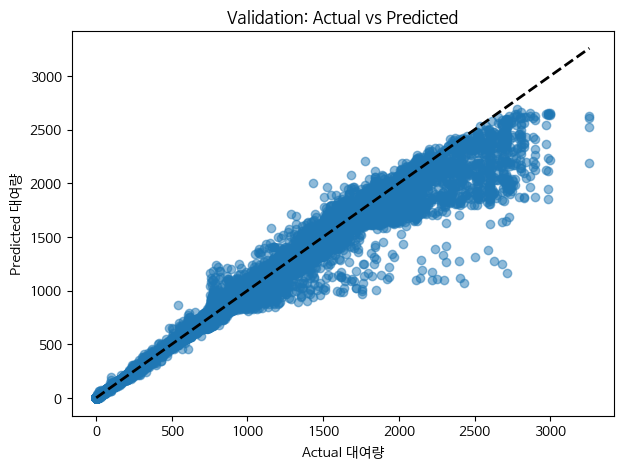

----- Test Set Evaluation -----
Test RMSE: 17.13, MAE: 4.00, R2: 0.995


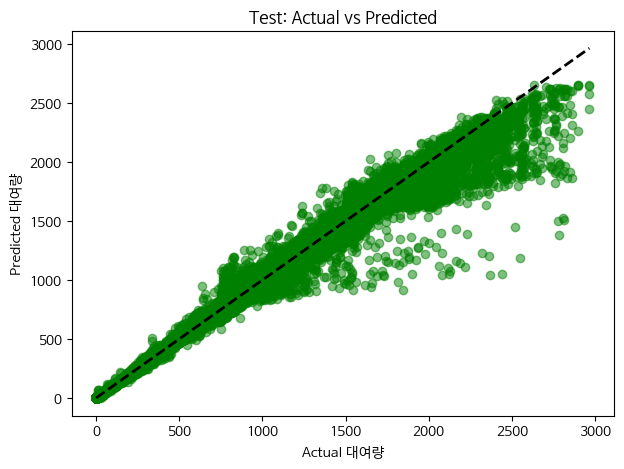

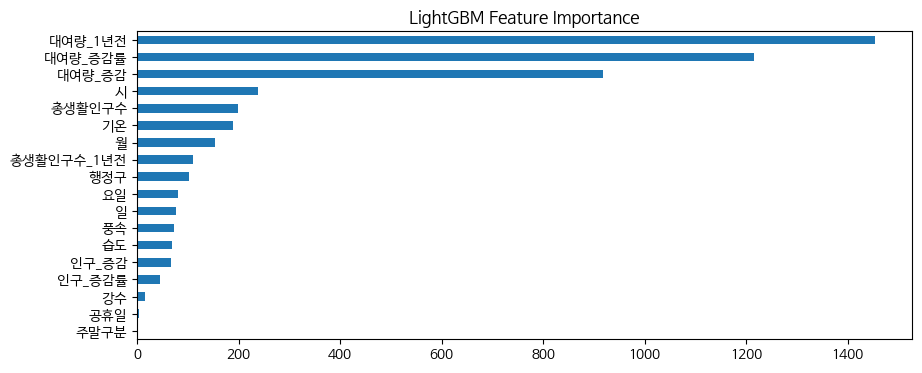

예측 대여량: 116.3


In [6]:
import pandas as pd
import numpy as np
import joblib
from datetime import datetime, timedelta
import holidays
import matplotlib.pyplot as plt
plt.rc('font',family = 'Hancom Gothic')
# 데이터 로딩 및 전처리
df = pd.read_csv('LSTM최종데이터_X_Y_라벨링등전.csv')
df = df.dropna(subset=['대여량'])

df['일시'] = pd.to_datetime(df['일시'])
df['연'] = df['일시'].dt.year
df['월'] = df['일시'].dt.month
df['일'] = df['일시'].dt.day
df['시'] = df['일시'].dt.hour
df['요일'] = df['일시'].dt.dayofweek
start_year = df['연'].min()
end_year = df['연'].max()
kr_holidays = holidays.KR(years=range(start_year, end_year+1))
df['공휴일'] = df['일시'].dt.floor('D').isin(kr_holidays).astype(int)

df['key'] = df['행정구'] + '_' + df['월'].astype(str) + '_' + df['일'].astype(str) + '_' + df['시'].astype(str)
df['일시_1년전'] = df['일시'] - pd.DateOffset(years=1)
df['key_1년전'] = df['행정구'] + '_' + df['일시_1년전'].dt.month.astype(str) + '_' + df['일시_1년전'].dt.day.astype(str) + '_' + df['일시_1년전'].dt.hour.astype(str)
cols_to_copy = ['key', '대여량', '총생활인구수']
df_1y = df[cols_to_copy].copy()
df_1y.columns = [c + '_1년전' if c != 'key' else 'key_1년전' for c in cols_to_copy]
df = pd.merge(df, df_1y, how='left', on='key_1년전')
df = df.dropna(subset=['대여량_1년전', '총생활인구수_1년전'])

df['인구_증감'] = df['총생활인구수'] - df['총생활인구수_1년전']
df['인구_증감률'] = (df['총생활인구수'] - df['총생활인구수_1년전']) / (df['총생활인구수_1년전'] + 1)
df['대여량_증감'] = df['대여량'] - df['대여량_1년전']
df['대여량_증감률'] = (df['대여량'] - df['대여량_1년전']) / (df['대여량_1년전'] + 1)

from sklearn.preprocessing import LabelEncoder, StandardScaler
label_cols = ['행정구']
le_dict = {}
for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

feature_cols = [
    '행정구', '월', '일', '시', '요일', '총생활인구수', '강수', '기온', '습도', '풍속',
    '주말구분', '공휴일',
    '대여량_1년전', '총생활인구수_1년전',
    '대여량_증감', '대여량_증감률', '인구_증감', '인구_증감률'
]
X = df[feature_cols]
y = df['대여량']

num_cols = [
    '총생활인구수', '강수', '기온', '습도', '풍속',
    '대여량_1년전', '총생활인구수_1년전',
    '대여량_증감', '대여량_증감률', '인구_증감', '인구_증감률'
]
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

train_idx = df['연'] <= 2022
val_idx = (df['연'] == 2023)
test_idx = (df['연'] == 2024)
X_train, X_val, X_test = X[train_idx], X[val_idx], X[test_idx]
y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx]

# --------- LightGBM 회귀 모델 ---------
import lightgbm as lgb

lgbm_reg = lgb.LGBMRegressor(
    objective='regression',
    random_state=42,
    n_estimators=300,
    learning_rate=0.1
)

callbacks = [
    lgb.early_stopping(stopping_rounds=20, first_metric_only=True, verbose=True),
    lgb.log_evaluation(20)
]

lgbm_reg.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=callbacks
)

# --------- 평가(검증/테스트) 및 시각화 ---------
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def regression_metrics(y_true, y_pred, title=""):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{title} RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.3f}")
    return rmse, mae, r2

# 검증셋
y_pred_val = lgbm_reg.predict(X_val)
print("----- Validation Set Evaluation -----")
regression_metrics(y_val, y_pred_val, title="Validation")

plt.figure(figsize=(7,5))
plt.scatter(y_val, y_pred_val, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.xlabel('Actual 대여량')
plt.ylabel('Predicted 대여량')
plt.title('Validation: Actual vs Predicted')
plt.show()

# 테스트셋
y_pred_test = lgbm_reg.predict(X_test)
print("----- Test Set Evaluation -----")
regression_metrics(y_test, y_pred_test, title="Test")

plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred_test, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual 대여량')
plt.ylabel('Predicted 대여량')
plt.title('Test: Actual vs Predicted')
plt.show()

# --------- 피처 중요도 시각화 ---------
plt.figure(figsize=(10,4))
imp = pd.Series(lgbm_reg.feature_importances_, index=feature_cols)
imp.sort_values().plot(kind='barh')
plt.title('LightGBM Feature Importance')
plt.show()

# --------- 예측 함수(LightGBM 회귀) ---------
joblib.dump(lgbm_reg, 'best_lgbm_reg_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le_dict, 'labelencoders.pkl')
joblib.dump(feature_cols, 'featurecols.pkl')
joblib.dump(num_cols, 'numcols.pkl')

def predict_bike_demand_regression(행정구, 강수, 습도, 풍속, 기온):
    """
    행정구명, 강수, 습도, 풍속, 기온을 입력받아
    해당 시간의 공공자전거 대여량을 예측(실수값)하는 함수 (LightGBM 회귀)
    """
    import pandas as pd
    import numpy as np
    import joblib
    from datetime import datetime, timedelta
    import holidays

    le_dict = joblib.load('labelencoders.pkl')
    scaler = joblib.load('scaler.pkl')
    feature_cols = joblib.load('featurecols.pkl')
    num_cols = joblib.load('numcols.pkl')
    model = joblib.load('best_lgbm_reg_model.pkl')

    now = datetime.now()
    년, 월, 일, 시 = now.year, now.month, now.day, now.hour
    요일 = now.weekday()
    주말구분 = 1 if 요일 >= 5 else 0
    kr_holidays = holidays.KR(years=[년])
    공휴일 = int(now.date() in kr_holidays)

    dt_1y = now - timedelta(days=365)
    년_1, 월_1, 일_1, 시_1 = dt_1y.year, dt_1y.month, dt_1y.day, dt_1y.hour
    row_1y = df[(df['행정구'] == le_dict['행정구'].transform([행정구])[0]) &
                (df['연'] == 년_1) & (df['월'] == 월_1) &
                (df['일'] == 일_1) & (df['시'] == 시_1)]
    if row_1y.empty:
        raise ValueError('1년 전 데이터가 존재하지 않습니다.')
    대여량_1년전 = row_1y['대여량'].values[0]
    총생활인구수_1년전 = row_1y['총생활인구수'].values[0]
    총생활인구수 = 총생활인구수_1년전

    대여량_증감 = 0
    대여량_증감률 = 0
    인구_증감 = 0
    인구_증감률 = 0

    input_dict = {
        '행정구': le_dict['행정구'].transform([행정구])[0],
        '월': 월,
        '일': 일,
        '시': 시,
        '요일': 요일,
        '총생활인구수': 총생활인구수,
        '강수': 강수,
        '기온': 기온,
        '습도': 습도,
        '풍속': 풍속,
        '주말구분': 주말구분,
        '공휴일': 공휴일,
        '대여량_1년전': 대여량_1년전,
        '총생활인구수_1년전': 총생활인구수_1년전,
        '대여량_증감': 대여량_증감,
        '대여량_증감률': 대여량_증감률,
        '인구_증감': 인구_증감,
        '인구_증감률': 인구_증감률
    }
    input_df = pd.DataFrame([input_dict])
    input_df[num_cols] = scaler.transform(input_df[num_cols])
    X_input = input_df[feature_cols].values
    pred = model.predict(X_input)
    return float(pred[0])

# 사용 예시
pred = predict_bike_demand_regression('강남구', 0.2, 60, 2.5, 21)
print(f"예측 대여량: {pred:.1f}")
